In [1]:
import torch

import xgboost as xgb
import pandas as pd
import numpy as np

from torch import nn as nn
from matplotlib import pyplot as plt

from joblib import load
from ml_correction import BuoyDataset, SimpleMLP, LessSimpleMLP, add_cyclic_time

In [2]:
def rmse(pred, target):
    return np.sqrt(np.mean((pred - target)**2))

#### Prepare data

In [3]:
path_data = "../dataset/"
buoys_df = pd.read_csv(f"{path_data}prepared_buoy_data.csv", index_col=[0, 1])
path_models = "models/"

X_scaler = load(f'{path_models}X_train_scaler.bin')

In [4]:
kvs = buoys_df.loc['KVS_SvalMIZ_10'].dropna()
kvs = kvs.set_index(pd.to_datetime(kvs.index))
kvs['residuals'] = kvs['temp_air'] - kvs['arome_t2m']
kvs['hour'] = kvs.index.hour
kvs['doy'] = kvs.index.day_of_year

X_data = kvs[['arome_t2m', 'sic', 'hour', 'doy']]
y_data = kvs[['residuals']]

X_test_time = X_data[['hour', 'doy']]
X_test = X_data.drop(['hour', 'doy'], axis = 1)

X_test_time = add_cyclic_time(X_test_time.copy())

X_test_scaled = X_scaler.transform(X_test)
X_test_scaled = np.concatenate(
    [X_test_scaled, X_test_time[['hour_sin', 'hour_cos', 'day_sin', 'day_cos']]], axis = 1
)
X_test = np.concatenate(
    [X_test, X_test_time[['hour_sin', 'hour_cos', 'day_sin', 'day_cos']]], axis = 1
)

test_dataset = BuoyDataset(X_test_scaled, y_data.to_numpy())
test_loader = torch.utils.data.DataLoader(test_dataset,  batch_size = 1, shuffle = False)

#### prepare models

In [5]:
model = torch.load(f"{path_models}best_simple_nn.pt", weights_only=False, map_location=torch.device('cpu'))
model.eval()

SimpleMLP(
  (network): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [6]:
fancy_model = torch.load(f"{path_models}best_diamond_dnn.pt", weights_only=False, map_location=torch.device('cpu'))
fancy_model.eval()

LessSimpleMLP(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=64, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.1, inplace=False)
    (16): Linear(in_features=64, out_features=32, bias=True)
    (17): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [7]:
xgb_model = xgb.XGBRegressor()
xgb_model.load_model(f"{path_models}xgboost_model.json")
print(xgb_model)

xgb_dayonly_model = xgb.XGBRegressor()
xgb_dayonly_model.load_model(f"{path_models}xgboost_dayonly_model.json")

XGBRegressor(base_score=[0.048641544], booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)


#### Validate model

In [9]:
test_preds = np.zeros(y_data.shape[0])
test_preds_fancy = np.zeros_like(test_preds)
test_preds_xgb = xgb_model.predict(X_test)
test_preds_xgbdo = xgb_dayonly_model.predict(X_test[:, -2:])
with torch.no_grad():
    for i, (X, y) in enumerate(test_loader):
        test_preds[i] = model(X)
        test_preds_fancy[i] = fancy_model(X)

        # print(f"residuals: {y.reshape(1, -1)}, y_pred: {test_preds[i].reshape(1, -1)}")

# test_preds = test_preds.reshape(-1, 1)

print()

In [10]:
kvs['NN_temp'] = kvs['arome_t2m'] + test_preds
kvs['FNN_temp'] = kvs['arome_t2m'] + test_preds_fancy
kvs['xgb_temp'] = kvs['arome_t2m'] + test_preds_xgb
kvs['xgbdo_temp'] = kvs['arome_t2m'] + test_preds_xgbdo

RMSE skill score

In [11]:
print(rmse(kvs['arome_t2m'], kvs['temp_air']))
print(rmse(kvs['NN_temp'], kvs['temp_air']))
print(rmse(kvs['FNN_temp'], kvs['temp_air']))
print(rmse(kvs['xgb_temp'], kvs['temp_air']))
print(rmse(kvs['xgbdo_temp'], kvs['temp_air']))

1.2707685432462252
0.9628124512655349
0.6560424583448147
0.38003622291036593
0.8656271878484165


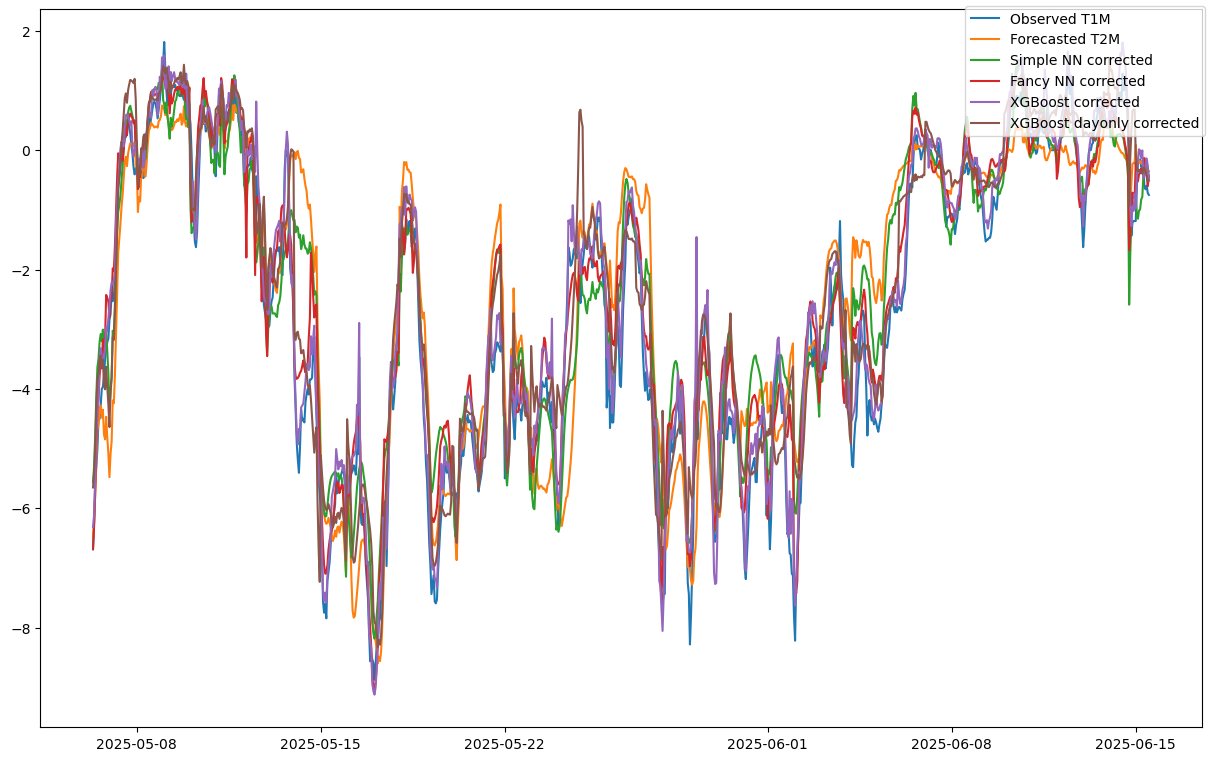

In [12]:
fig, ax = plt.subplots(figsize = (12, 7.5), constrained_layout = True)

ax.plot(kvs.index, kvs['temp_air'], label = 'Observed T1M')
aa_line, = ax.plot(kvs.index, kvs['arome_t2m'], label = 'Forecasted T2M')
nn_line, = ax.plot(kvs.index, kvs['NN_temp'], label = 'Simple NN corrected')
fnn_line, = ax.plot(kvs.index, kvs['FNN_temp'], label = 'Fancy NN corrected')
xgb_line, = ax.plot(kvs.index, kvs['xgb_temp'], label = 'XGBoost corrected')
xgbdo_line, = ax.plot(kvs.index, kvs['xgbdo_temp'], label = 'XGBoost dayonly corrected')

fig.legend()

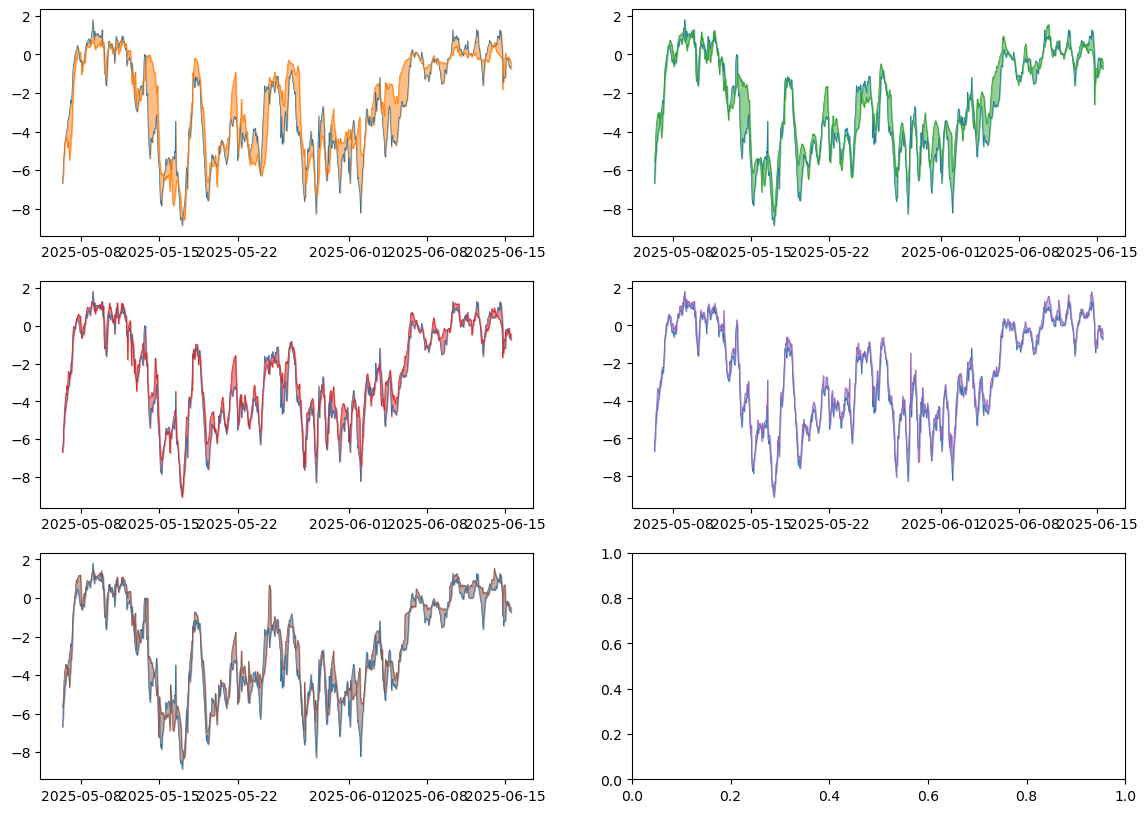

In [13]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (14, 10))

ax[0,0].plot(kvs.index, kvs['temp_air'], label = 'Observed T1M', linewidth = 0.5)
ax[0,0].plot(kvs.index, kvs['arome_t2m'], label = 'Forecasted T2M', linewidth = 0.5)
ax[0,0].fill_between(kvs.index, kvs['temp_air'], kvs['arome_t2m'], alpha = .5, color = aa_line.get_color())

ax[0,1].plot(kvs.index, kvs['temp_air'], label = 'Observed T1M', linewidth = 0.5)
ax[0,1].plot(kvs.index, kvs['NN_temp'], label = 'NN corrected T2M', linewidth = .5, color = nn_line.get_color())
ax[0,1].fill_between(kvs.index, kvs['temp_air'], kvs['NN_temp'], alpha = .5, color = nn_line.get_color())

ax[1,0].plot(kvs.index, kvs['temp_air'], label = 'Observed T1M', linewidth = 0.5)
ax[1,0].plot(kvs.index, kvs['FNN_temp'], label = 'Fancy NN corrected T2M', linewidth = 0.5, color = fnn_line.get_color())
ax[1,0].fill_between(kvs.index, kvs['temp_air'], kvs['FNN_temp'], alpha = .5, color = fnn_line.get_color())

ax[1,1].plot(kvs.index, kvs['temp_air'], label = 'Observed T1M', linewidth = 0.5)
ax[1,1].plot(kvs.index, kvs['xgb_temp'], label = 'xgb corrected T2M', linewidth = .5, color = xgb_line.get_color())
ax[1,1].fill_between(kvs.index, kvs['temp_air'], kvs['xgb_temp'], alpha = .5, color = xgb_line.get_color())

ax[2,0].plot(kvs.index, kvs['temp_air'], label = 'Observed T1M', linewidth = 0.5)
ax[2,0].plot(kvs.index, kvs['xgbdo_temp'], label = 'xgb day only corrected T2M', linewidth = .5, color = xgbdo_line.get_color())
ax[2,0].fill_between(kvs.index, kvs['temp_air'], kvs['xgbdo_temp'], alpha = .5, color = xgbdo_line.get_color())

#### Predictor importance xgboost

Explanation fetched from [StackExchange](https://datascience.stackexchange.com/questions/12318/how-to-interpret-the-output-of-xgboost-importance)

The meaning of the importance data table is as follows:

*The Gain implies the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.*

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

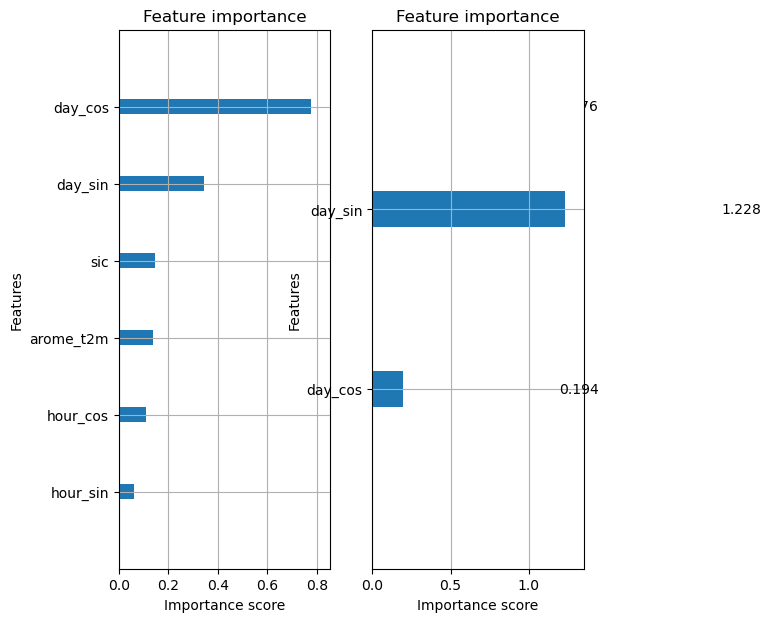

In [14]:
fig, ax = plt.subplots(figsize = (6, 7), ncols = 2)

xgb_model.get_booster().feature_names = ['arome_t2m', 'sic', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']
xgb.plot_importance(xgb_model, importance_type='gain', ax = ax[0], show_values = True, values_format = "{v:.3f}")


xgb_dayonly_model.get_booster().feature_names = ['day_sin', 'day_cos']
xgb.plot_importance(xgb_dayonly_model, importance_type='gain', ax = ax[1], show_values = True, values_format = "{v:.3f}")

Are's notes:

I find it interesting that the most important predictor(s) is(are) the cosine(and sine) component of the day, given that the dataset features a very limited view of the year (only a couple months from april to july), nevertheless, it might indicate that the overall periodicity of the temperature is a well defined "hyperplane" captured by the xgboost and as such is important for making corrections. Thus, I suspect that the model uses the parameters in the following ways:
The physical parameters arome_t2m and sic, is used to "initialize" the model so it knows what to correct, whereas the preiodic "day" is used by the model to infer a seasonality which tells to which extent the physical parameters shall be corrected. Surprisingly, the time components have little contribution to the predictions, indicating that the time of day is less important to correct, but might contribute to the initialization of the model. What I mean by "initialization" is that I believe the model would not make meaningful predictions with just the sine and cosine of the day (although this should be checked). 